In [1]:
import re
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
wnl = WordNetLemmatizer()
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer =TfidfVectorizer(max_features=5000)
from sklearn.metrics import accuracy_score

In [2]:
with open('./Genre Classification Dataset/train_data.txt','r',encoding='utf-8') as fileobj:
    train = fileobj.readlines()
with open('./Genre Classification Dataset/test_data.txt','r',encoding='utf-8') as fileobj:
    test_X = fileobj.readlines()
with open('./Genre Classification Dataset/test_data_solution.txt','r',encoding='utf-8') as fileobj:
    test_y = fileobj.readlines()

In [3]:
train_rows = []
for i in train:
    train_rows.append(i.split(':::'))
test_X_rows = []
for i in test_X:
    test_X_rows.append(i.split(':::'))
test_y_rows = []
for i in test_y:
    test_y_rows.append(i.split(':::'))

In [4]:
train_df = pd.DataFrame(train_rows,columns=['ID','TITLE','GENRE','DESCRIPTION'])
test_X_df = pd.DataFrame(test_X_rows,columns=['ID','TITLE','DESCRIPTION'])
test_y_df = pd.DataFrame(test_y_rows,columns=['ID','TITLE','GENRE','DESCRIPTION'])

In [5]:
train_df.head()

,ID,TITLE,GENRE,DESCRIPTION
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [6]:
test_X_df.head()

,ID,TITLE,DESCRIPTION
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


In [9]:
test_y_df.head()

,ID,TITLE,GENRE,DESCRIPTION
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a mart...


## Basic EDA

In [40]:
vc = train_df['GENRE'].value_counts()

In [80]:
vc

GENRE
 drama           13613
 documentary     13096
 comedy           7447
 short            5073
 horror           2204
 thriller         1591
 action           1315
 western          1032
 reality-tv        884
 family            784
 adventure         775
 music             731
 romance           672
 sci-fi            647
 adult             590
 crime             505
 animation         498
 sport             432
 talk-show         391
 fantasy           323
 mystery           319
 musical           277
 biography         265
 history           243
 game-show         194
 news              181
 war               132
Name: count, dtype: int64

#### There are totally 27 genres..

<Axes: xlabel='count', ylabel='GENRE'>

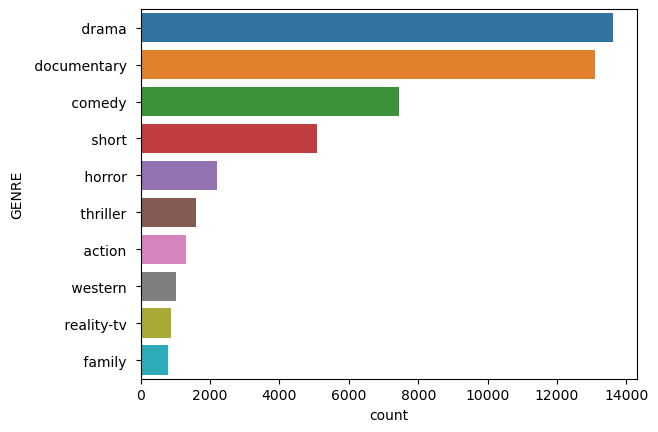

In [84]:
sns.countplot(data=train_df,y='GENRE',order=vc.index[:10])

#### Top 10 genres based on count

In [213]:
drama = 13613
documentary = 13096
total = 54214
print(f"DRAMA : {drama/total * 100}%")
print(f"DOCUMENTARY : {documentary/total * 100}%")

DRAMA : 25.109750249013167%
DOCUMENTARY : 24.156122034898736%


#### Drama and documentary are the most genre for most of the films drama: 25% and documentary: 24%

In [221]:
#for extracting the year from the movie title
year_df = pd.DataFrame(train_df['TITLE'].str.strip().str.split(' ').apply(lambda x:x[-1].replace('(','').replace(')','')[:4])).rename(columns={"TITLE":"YEAR"})

In [223]:
# To extract only the year instead of any other words
def extract_year(text):
    match = re.search(r'\b(19|20)\d{2}\b', text)
    return match.group(0) if match else np.nan

In [224]:
year_df['YEAR'] = year_df['YEAR'].apply(lambda x : extract_year(x))

In [225]:
vc = year_df['YEAR'].value_counts()

<Axes: xlabel='count', ylabel='YEAR'>

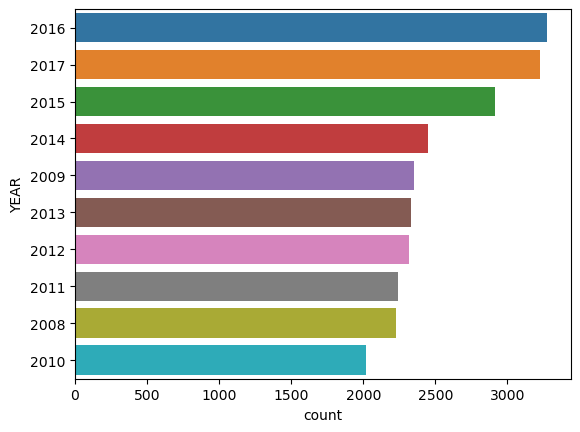

In [226]:
sns.countplot(data=year_df,y='YEAR',order=vc.index[:10])

In [220]:
total = 54214
print(f"2016 : {3275/total * 100}%")
print(f"2017 : {3223/total * 100}%")

2016 : 6.040875050724905%
2017 : 5.944958866713395%


#### Most of the films are in the year of 2016 and 2017 with percent of 6 and 5

In [230]:
year_df.dropna(inplace=True)

In [232]:
year_df['YEAR'] = year_df['YEAR'].astype('int')

C:\Users\susil\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


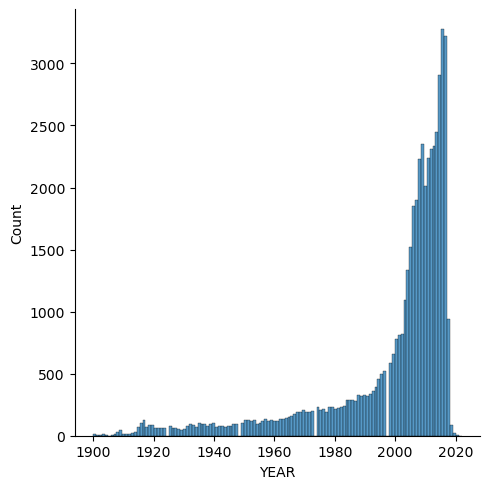

In [234]:
sns.displot(year_df['YEAR'])

#### With this distribution we basically could get that most of the films is around 2005 to 2020

## Preprocessing

In [6]:
train_df.isnull().sum()

ID             0
TITLE          0
GENRE          0
DESCRIPTION    0
dtype: int64

In [7]:
test_y_df.isnull().sum()

ID             0
TITLE          0
GENRE          0
DESCRIPTION    0
dtype: int64

In [6]:
df = pd.concat([train_df,test_y_df],axis=0)

In [6]:
df.shape

(108414, 4)

In [7]:
df.reset_index(drop=True,inplace=True)

In [8]:
df.head()

,ID,TITLE,GENRE,DESCRIPTION
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [9]:
df['GENRE_ENCODED'] = label_encoder.fit_transform(df['GENRE'])

In [10]:
def lower(text):
    return text.lower()

In [11]:
stop_words = stopwords.words('english')

In [12]:
def preprocessing(text):
    text = lower(text)
    corpus = [wnl.lemmatize(word,pos='v') for word in word_tokenize(text,'english') if word not in stop_words]
    corpus = [i.replace(',','').replace('.','') for i in corpus]
    return ' '.join(corpus)

In [13]:
df['DESCRIPTION'] = df['DESCRIPTION'].apply(lambda x: preprocessing(x))

In [14]:
df['DESCRIPTION'][0]

'listen conversation doctor parent  10-year-old oscar learn nobody courage tell  weeks live  furious  refuse speak anyone except straight-talking rise  lady pink meet hospital stairs  christmas approach  rise use fantastical experience professional wrestler  imagination  wit charm allow oscar live life love full  company friends pop corn  einstein  bacon childhood sweetheart peggy blue '

## Vectorzing

In [15]:
df.head()

,ID,TITLE,GENRE,DESCRIPTION,GENRE_ENCODED
0,1,Oscar et la dame rose (2009),drama,listen conversation doctor parent 10-year-old...,8
1,2,Cupid (1997),thriller,brother sister past incestuous relationship cu...,24
2,3,"Young, Wild and Wonderful (1980)",adult,bus empty students field trip museum natural h...,1
3,4,The Secret Sin (1915),drama,help unemployed father make end meet edith tw...,8
4,5,The Unrecovered (2007),drama,film 's title refer un-recovered body grind ze...,8


In [16]:
X = df['DESCRIPTION']
y = df['GENRE_ENCODED']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [18]:
vector_X_train = vectorizer.fit_transform(X_train)
vector_X_test = vectorizer.transform(X_test)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
svc = SVC()
lr = LogisticRegression(n_jobs=1,max_iter=1000)
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
mnb = MultinomialNB()

In [20]:
algo = {
    "logistic regression":LogisticRegression(max_iter=1000),
    "DecisionTreeClassifier":DecisionTreeClassifier(),
    "RandomForestClassifier":RandomForestClassifier(),
    "MultinomialNB":MultinomialNB() 
}

In [52]:
predicted_scores = {}
for key,alg in tqdm(algo.items()):
    alg.fit(vector_X_train,y_train)
    y_pred = alg.predict(vector_X_test)
    score = accuracy_score(y_test,y_pred)
    predicted_scores[key] = score
    print(f"{key} completed")

 25%|█████████████████████                                                               | 1/4 [01:00<03:02, 60.91s/it]

logistic regression completed


 50%|█████████████████████████████████████████▌                                         | 2/4 [03:25<03:40, 110.39s/it]

DecisionTreeClassifier completed


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [10:24<00:00, 156.07s/it]

RandomForestClassifier completed
MultinomialNB completed


In [54]:
for algo,acc in predicted_scores.items():
    print(f"{algo}: {acc}\n")

logistic regression: 0.5964166922883417

DecisionTreeClassifier: 0.36288677083042176

RandomForestClassifier: 0.5028090672778601

MultinomialNB: 0.5329681080023478



In [21]:
lr.fit(vector_X_train,y_train)

LogisticRegression(max_iter=1000, n_jobs=1)

In [22]:
accuracy_score(y_train,lr.predict(vector_X_train))

0.6658039291270289

In [23]:
accuracy_score(y_test,lr.predict(vector_X_test))

0.5964166922883417

In [24]:
mnb.fit(vector_X_train,y_train)

MultinomialNB()

In [25]:
accuracy_score(y_train,mnb.predict(vector_X_train))

0.5512479865633217

In [26]:
accuracy_score(y_test,mnb.predict(vector_X_test))

0.5329681080023478

#### We could see logistic regression is overfitting we go for mulitnomial nb

In [67]:
label_encoder.classes_

array([' action ', ' adult ', ' adventure ', ' animation ', ' biography ',
       ' comedy ', ' crime ', ' documentary ', ' drama ', ' family ',
       ' fantasy ', ' game-show ', ' history ', ' horror ', ' music ',
       ' musical ', ' mystery ', ' news ', ' reality-tv ', ' romance ',
       ' sci-fi ', ' short ', ' sport ', ' talk-show ', ' thriller ',
       ' war ', ' western '], dtype=object)

In [35]:
m_name = input("Enter movie name: ")
m_plot = input("Enter movie plot: ")
preprocessed = preprocessing(m_plot)
vec = vectorizer.transform([preprocessed])
pred = mnb.predict(vec)
print(f"Movie name: {m_name} is {label_encoder.inverse_transform(pred)[0]} genre.")

Enter movie name:  red notice
Enter movie plot:  Red Notice is a 2021 American action comedy film written and directed by Rawson Marshall Thurber starring Dwayne Johnson alongside Ryan Reynolds, Gal Gadot and Ritu Arya. It marks the third collaboration between Thurber and Johnson, following Central Intelligence (2016) and Skyscraper (2018). In the film, an FBI agent reluctantly teams up with a renowned art thief in order to catch an even more notorious thief.


Movie name: red notice is  comedy  genre.
